In [76]:
import xarray as xr
import xesmf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load TPXO data and MOM6 grid

In [5]:
tpxo_h = xr.open_dataset("./GLOBAL_TXPO/h_tpxo9.v5a.nc")
tpxo_u = xr.open_dataset("./GLOBAL_TXPO/u_tpxo9.v5a.nc")
tpxo_grid = xr.open_dataset("./GLOBAL_TXPO/gridtpxo9v5a.nc")

In [6]:
tpxo_h["con"]

<xarray.DataArray 'con' (nc: 22)>
array([b'm2  ', b's2  ', b'n2  ', b'k2  ', b'k1  ', b'o1  ', b'p1  ', b'q1  ',
       b'mm  ', b'mf  ', b'm4  ', b'mn4 ', b'ms4 ', b'2n2 ', b's1  ', b'2q1 ',
       b'j1  ', b'l2  ', b'm3  ', b'mu2 ', b'nu2 ', b'oo1 '], dtype='|S4')
Dimensions without coordinates: nc
Attributes:
    log_name:  tidal constituents

In [8]:
hgrid = xr.open_dataset("/home/nicole/SWA14/gridgen/bathy_edited/ocean_hgrid.nc")

In [9]:
print("lon", hgrid["x"].min().values, hgrid["x"].max().values)
print("lat", hgrid["y"].min().values, hgrid["y"].max().values)

lon -69.0 -9.0
lat -55.0 5.0


Define the segments for remapping

In [33]:
# northern boundary
north = xr.Dataset()
north['lon'] = hgrid['x'].isel(nyp=-1)
north['lat'] = hgrid['y'].isel(nyp=-1)

# southern boundary
south = xr.Dataset()
south['lon'] = hgrid['x'].isel(nyp=0)
south['lat'] = hgrid['y'].isel(nyp=0)

# eastern boundary
east = xr.Dataset()
east['lon'] = hgrid['x'].isel(nxp=-1)
east['lat'] = hgrid['y'].isel(nxp=-1)

segments={'north':north, 'south':south, 'east':east}


### Clean up the raw data from TPXO and make it xarray-friendly

In [35]:
tpxo_h["lon"] = tpxo_grid["lon_z"]
tpxo_h["lat"] = tpxo_grid["lat_z"]
tpxo_h["mask"] = tpxo_grid["mz"]
tpxo_h = tpxo_h.transpose(*("nc", "ny", "nx"))
tpxo_h = tpxo_h.set_coords(["lon", "lat"])

tpxo_u["lon"] = tpxo_grid["lon_u"]
tpxo_u["lat"] = tpxo_grid["lat_u"]
tpxo_u["mask"] = tpxo_grid["mu"]
tpxo_u = tpxo_u.transpose(*("nc", "ny", "nx"))
tpxo_u = tpxo_u.set_coords(["lon", "lat"])

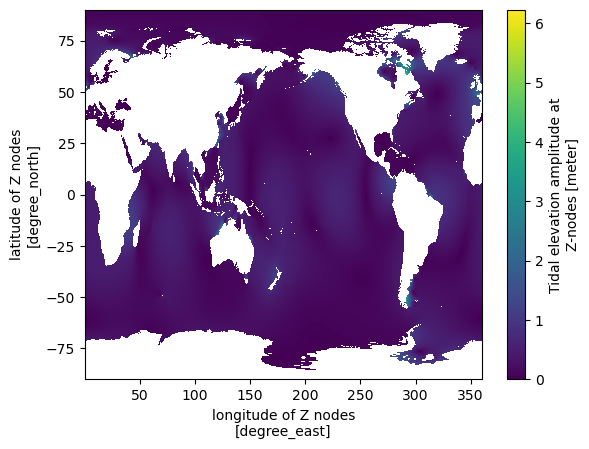

In [36]:
tpxo_h["ha"].isel(nc=0).where(tpxo_h["mask"] != 0.).plot(x="lon", y="lat")

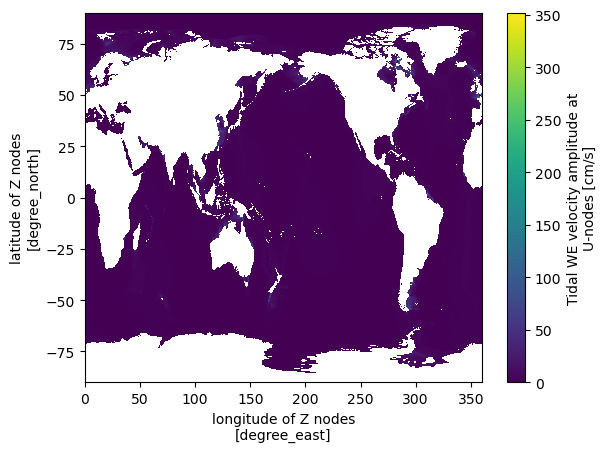

In [40]:
tpxo_u["ua"].isel(nc=0).where(tpxo_u["mask"] != 0.).plot(x="lon", y="lat")

### Subset to regional domain for compute efficiency

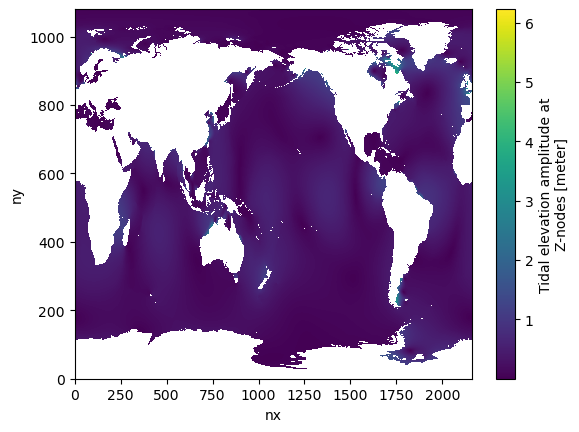

In [13]:
tpxo_h["ha"].isel(nc=0).where(tpxo_h["mask"] != 0.).plot()

In [14]:
horizontal_subset = dict(nx=slice(1700,2200), ny=slice(100,600)) #select the domain

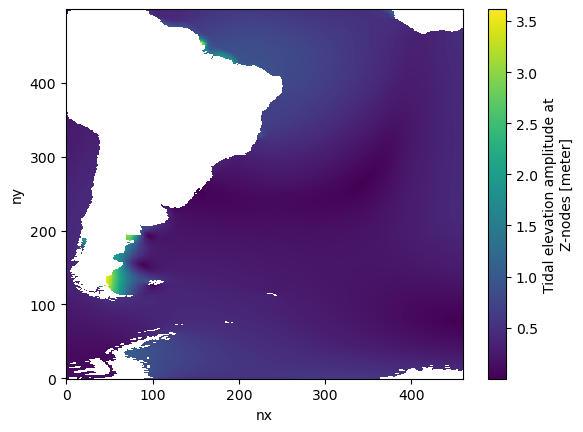

In [15]:
tpxo_h["ha"].where(tpxo_h["mask"] != 0.).sel(**horizontal_subset).isel(nc=0).plot()

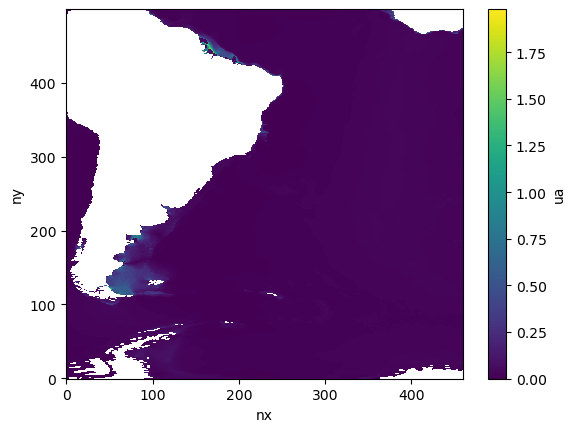

In [54]:
(tpxo_u["ua"]*1e-2).where(tpxo_u["mask"] != 0.).sel(**horizontal_subset).isel(nc=0).plot()

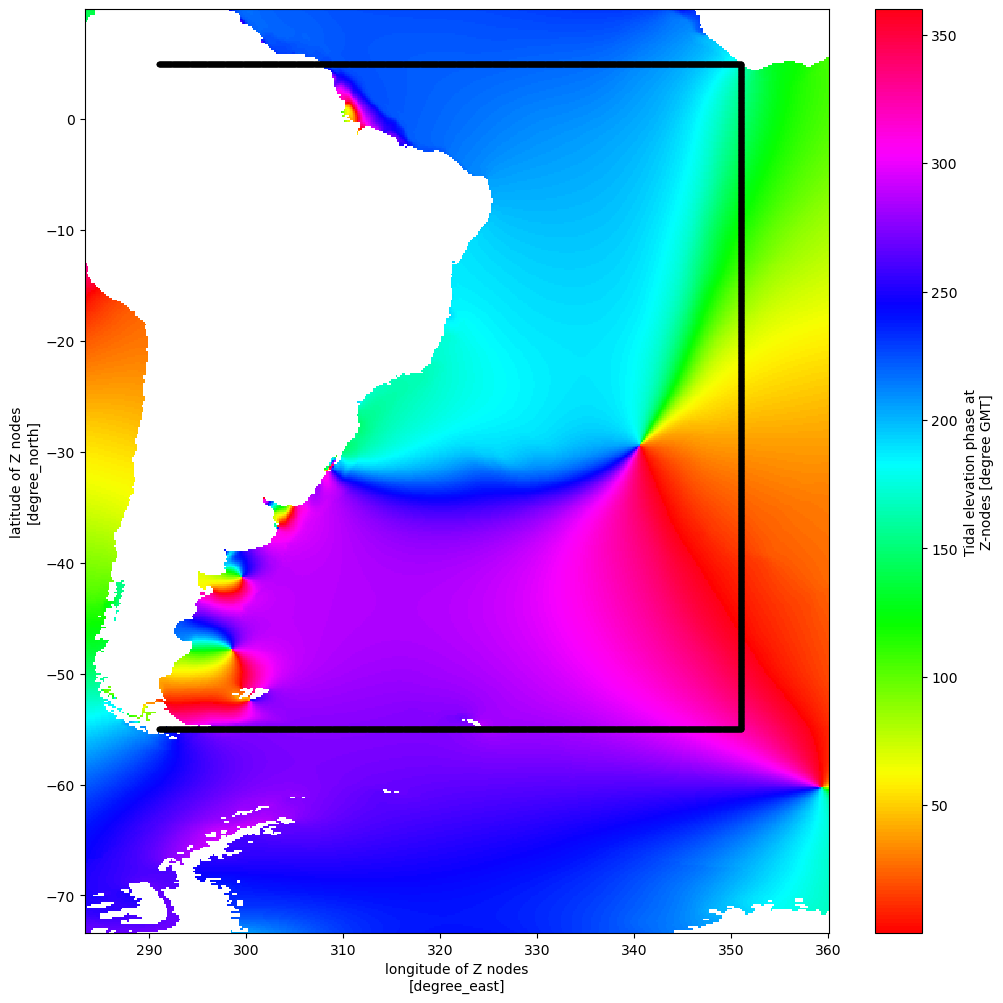

In [16]:
plt.figure(figsize=[12,12])
ax = plt.axes()
tpxo_h["hp"].where(tpxo_h["mask"] != 0.).sel(**horizontal_subset).isel(nc=0).plot(ax=ax, cmap="hsv", x="lon", y="lat")
ax.plot(north["lon"]+360, north["lat"], "k.")
ax.plot(south["lon"]+360, south["lat"], "k.")
ax.plot(east["lon"]+360, east["lat"], "k.")

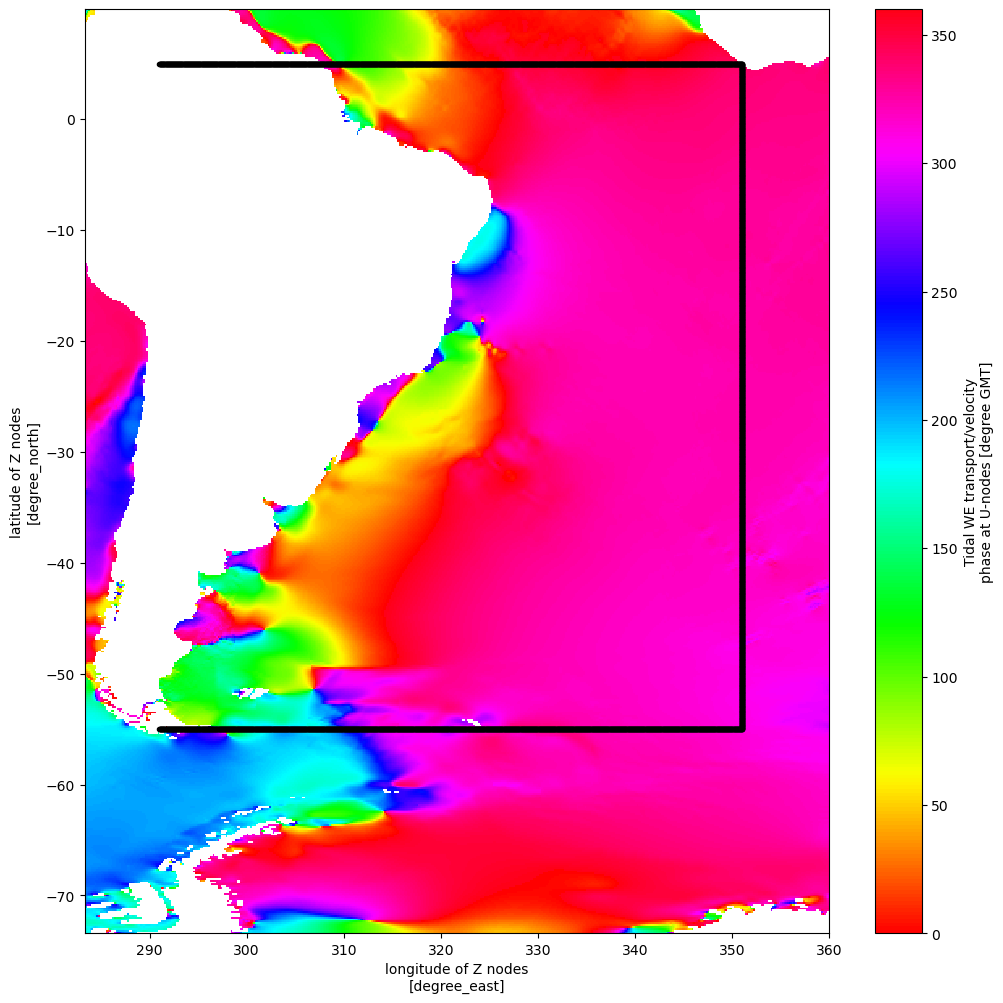

In [47]:
plt.figure(figsize=[12,12])
ax = plt.axes()
tpxo_u["up"].where(tpxo_u["mask"] != 0.).sel(**horizontal_subset).isel(nc=0).plot(ax=ax, cmap="hsv", x="lon", y="lat")
ax.plot(north["lon"]+360, north["lat"], "k.")
ax.plot(south["lon"]+360, south["lat"], "k.")
ax.plot(east["lon"]+360, east["lat"], "k.")

In [17]:
tpxo_h_reg = tpxo_h.sel(**horizontal_subset)
tpxo_h_reg

In [41]:
tpxo_u_reg = tpxo_u.sel(**horizontal_subset)
tpxo_u_reg

<xarray.Dataset>
Dimensions:  (nc: 22, ny: 500, nx: 460)
Coordinates:
    lon      (ny, nx) float64 ...
    lat      (ny, nx) float64 ...
Dimensions without coordinates: nc, ny, nx
Data variables: (12/16)
    con      (nc) |S4 b'm2  ' b's2  ' b'n2  ' ... b'mu2 ' b'nu2 ' b'oo1 '
    lon_u    (ny, nx) float32 ...
    lat_u    (ny, nx) float32 ...
    lon_v    (ny, nx) float32 ...
    lat_v    (ny, nx) float32 ...
    Ua       (nc, ny, nx) float32 ...
    ...       ...
    vp       (nc, ny, nx) float32 ...
    URe      (nc, ny, nx) float32 ...
    UIm      (nc, ny, nx) float32 ...
    VRe      (nc, ny, nx) float32 ...
    VIm      (nc, ny, nx) float32 ...
    mask     (ny, nx) float64 ...
Attributes:
    type:     OTIS tidal transport file
    title:    TPXO9.v5a 2021 transport/current file: open ocean TPXO9.v2, coa...

# Remap TPXO to various segments:

In [19]:
regrid_north = xesmf.Regridder(tpxo_h_reg, north, 'bilinear', 
                               locstream_out=True, periodic=False)

regrid_south = xesmf.Regridder(tpxo_h_reg, south, 'bilinear', 
                               locstream_out=True, periodic=False)

regrid_east = xesmf.Regridder(tpxo_h_reg, east, 'bilinear', 
                               locstream_out=True, periodic=False)

Create weight file: bilinear_500x460_1x1715.nc
Overwrite existing file: bilinear_500x460_1x1715.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: bilinear_500x460_1x1715.nc 
 You can set reuse_weights=True to save computing time.


In [20]:
amplitude_north = regrid_north(tpxo_h_reg["ha"])

/home/nicole/anaconda3/envs/gridTools/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [21]:
phase_north = regrid_north(tpxo_h_reg["hp"])

In [22]:
amplitude_south = regrid_south(tpxo_h_reg["ha"])

In [23]:
phase_south = regrid_south(tpxo_h_reg["hp"])

In [24]:
amplitude_east = regrid_east(tpxo_h_reg["ha"])

In [25]:
phase_east = regrid_east(tpxo_h_reg["hp"])

Dictionaries: practical use

In [43]:
regrid={}; amplitude={}; phase={}; v_amplitude={}; u_amplitude={} ; u_phase ={} ; v_phase={}
for b in segments:
    regrid[b] = xesmf.Regridder(tpxo_h_reg, segments[b], 'bilinear', 
                               locstream_out=True, periodic=False)

    amplitude[b] = regrid[b](tpxo_h_reg["ha"])
    phase[b] = regrid[b](tpxo_h_reg["hp"])
    
    v_amplitude[b] = regrid[b](tpxo_u_reg["va"])
    v_phase[b] = regrid[b](tpxo_u_reg["vp"])
    
    u_amplitude[b] = regrid[b](tpxo_u_reg["ua"])
    u_phase[b] = regrid[b](tpxo_u_reg["up"])    

Overwrite existing file: bilinear_500x460_1x1715.nc 
 You can set reuse_weights=True to save computing time.


/home/nicole/anaconda3/envs/gridTools/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_500x460_1x1715.nc 
 You can set reuse_weights=True to save computing time.


/home/nicole/anaconda3/envs/gridTools/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Overwrite existing file: bilinear_500x460_1x1715.nc 
 You can set reuse_weights=True to save computing time.


/home/nicole/anaconda3/envs/gridTools/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


### Northern boundary

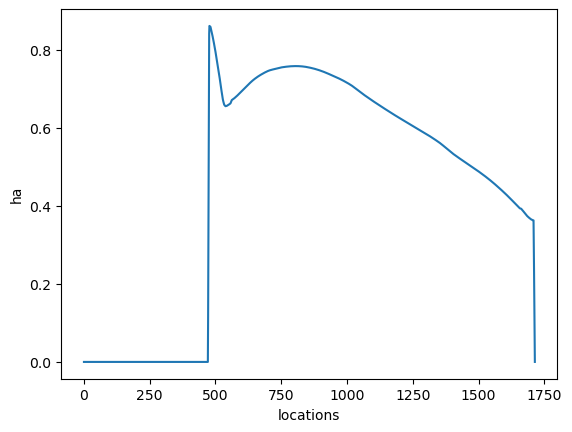

In [26]:
amplitude_north.isel(nc=0).plot()

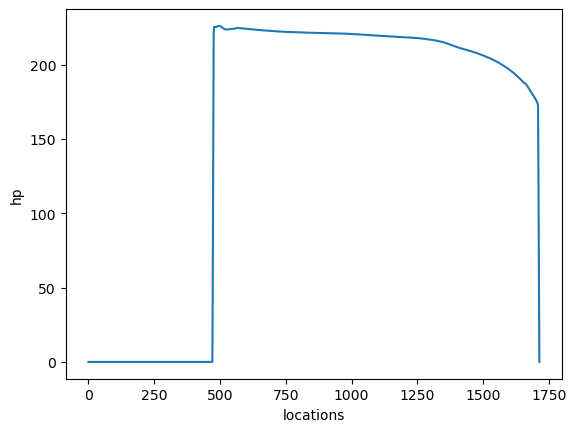

In [27]:
phase_north.isel(nc=0).plot()

## Southern boundary

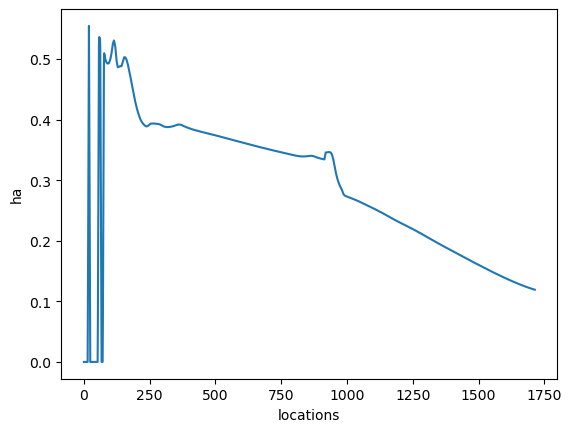

In [28]:
amplitude_south.isel(nc=0).plot()

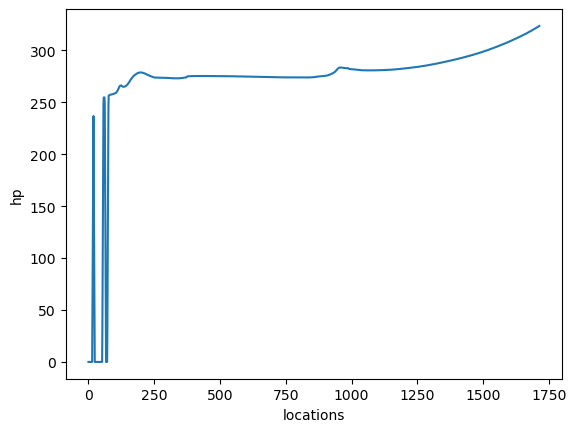

In [29]:
phase_south.isel(nc=0).plot()

### Eastern boundary

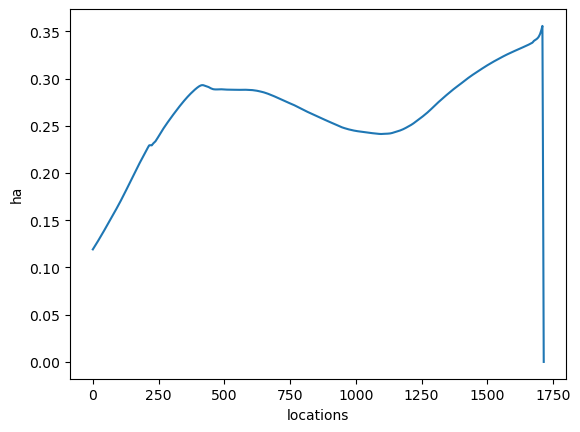

In [30]:
amplitude_east.isel(nc=0).plot()

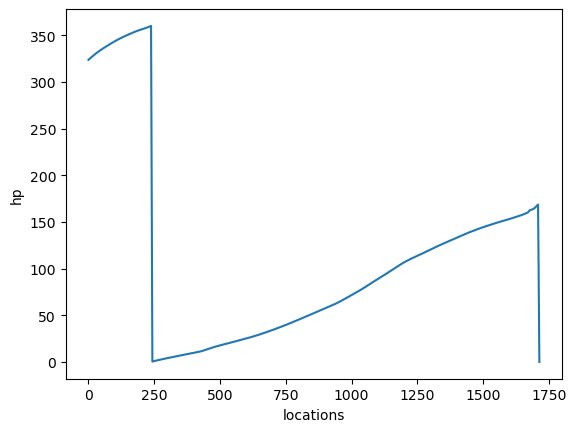

In [31]:
phase_east.isel(nc=0).plot()

## Prepare to create output

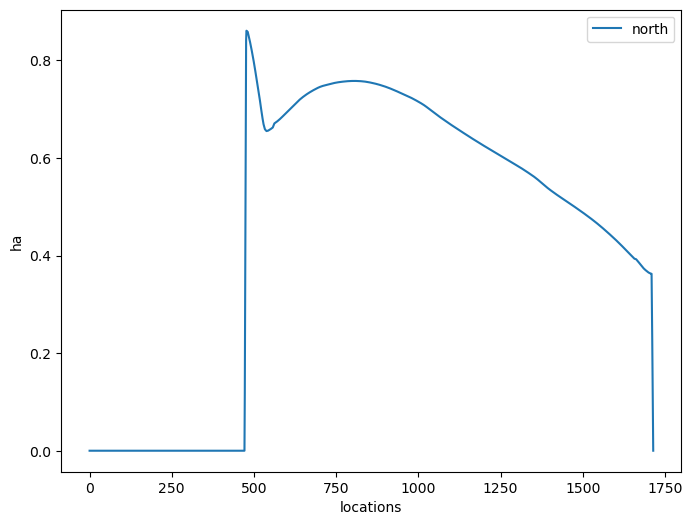

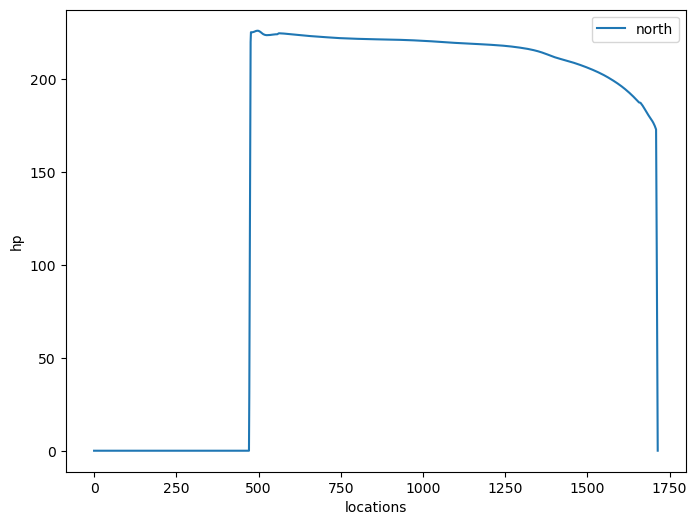

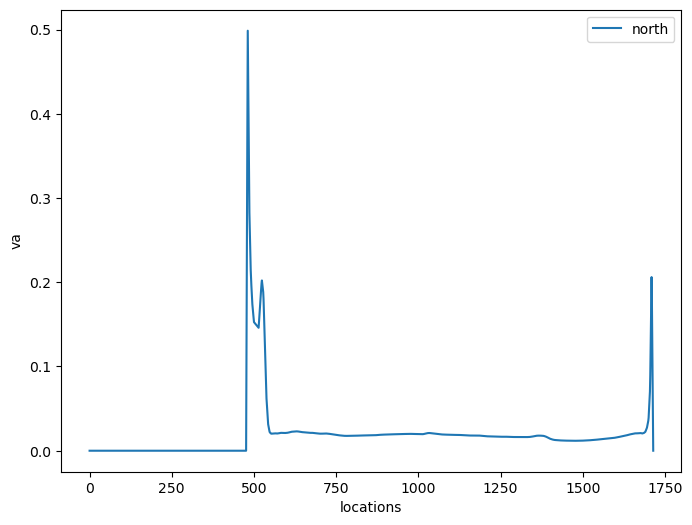

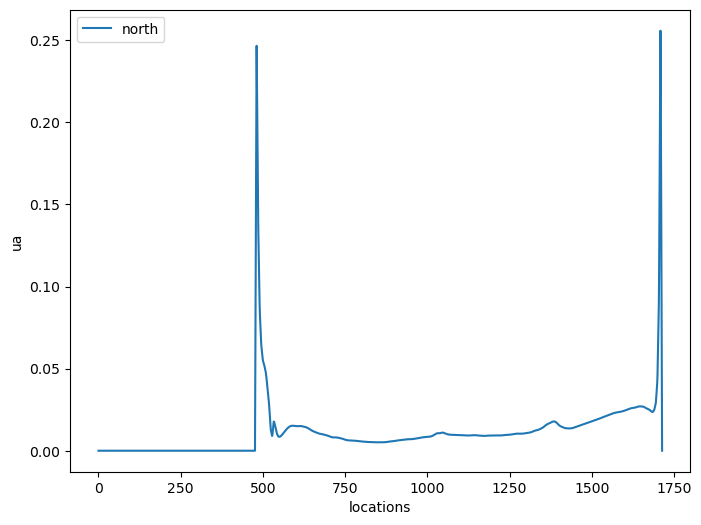

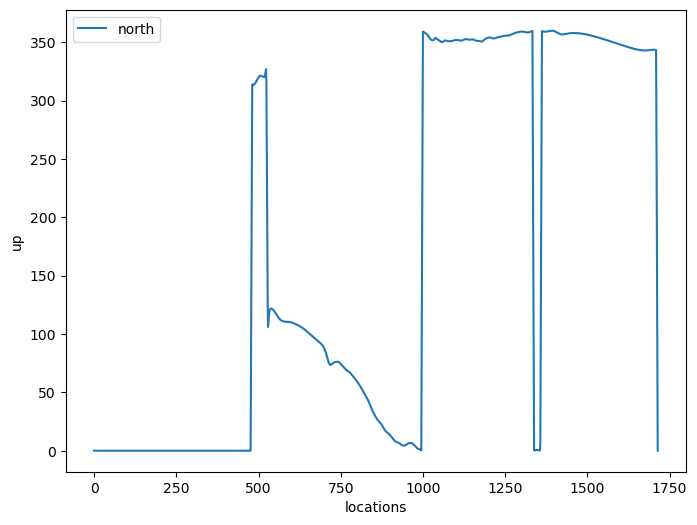

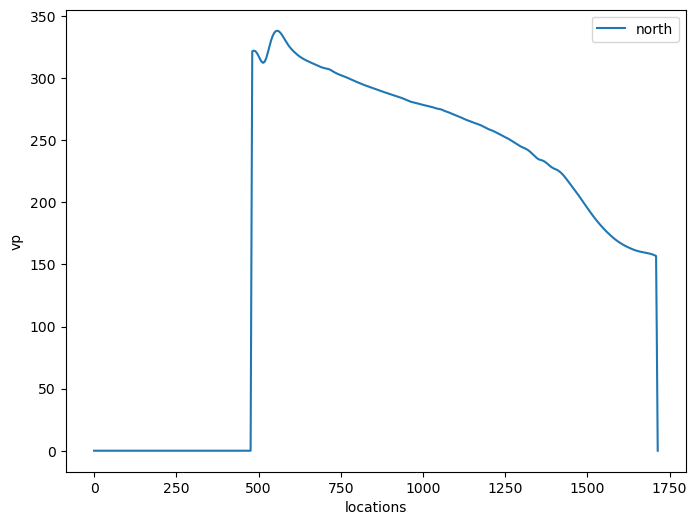

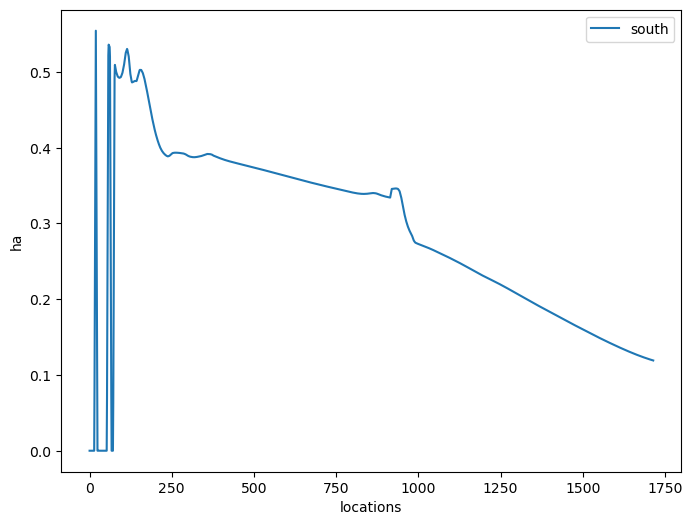

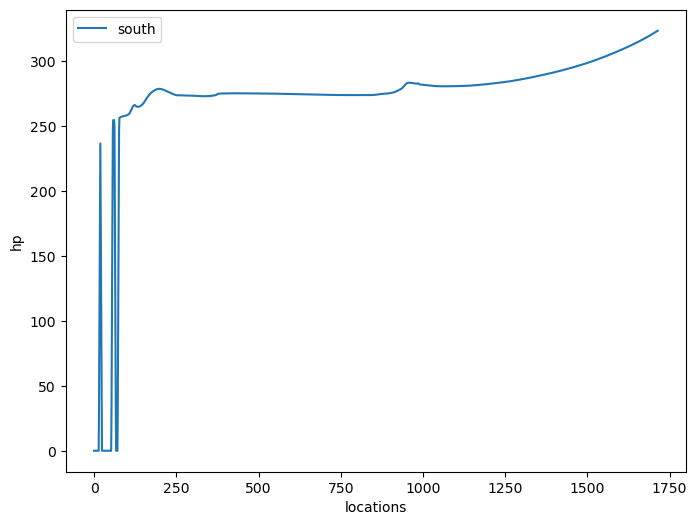

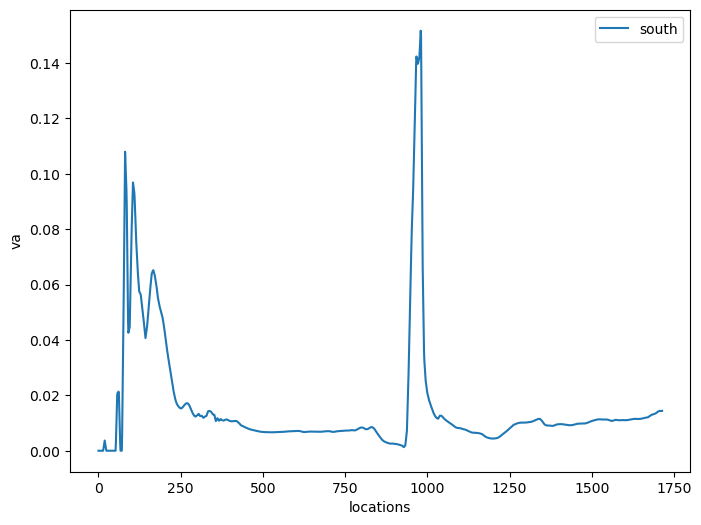

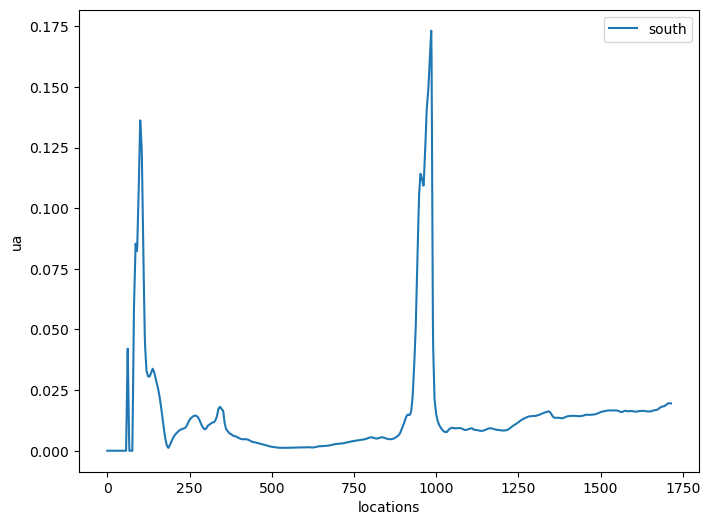

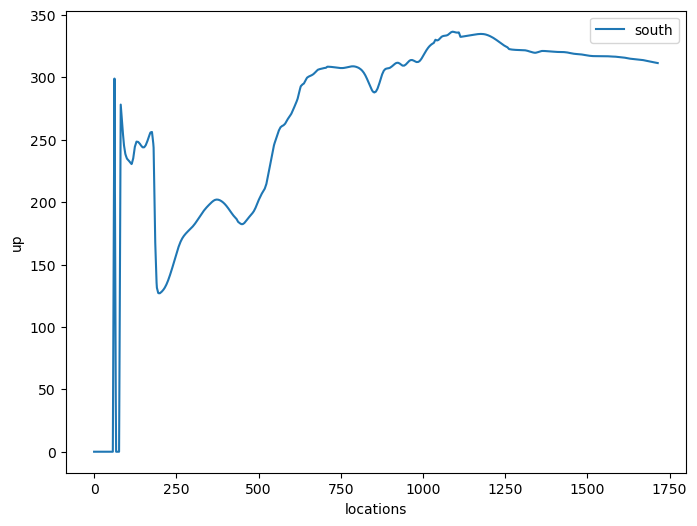

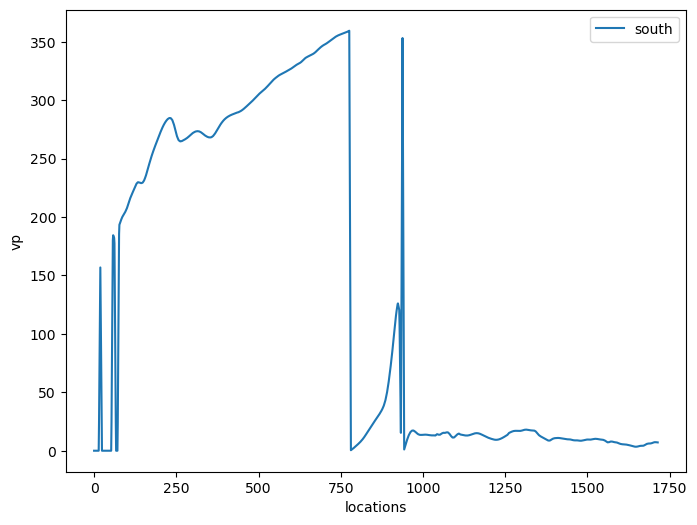

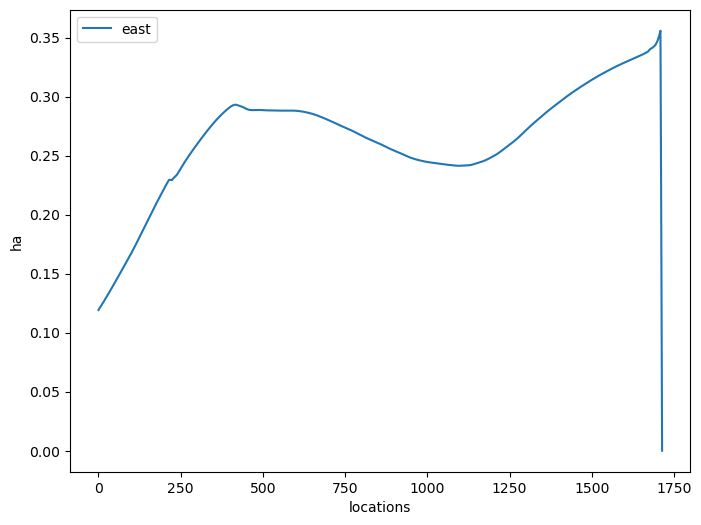

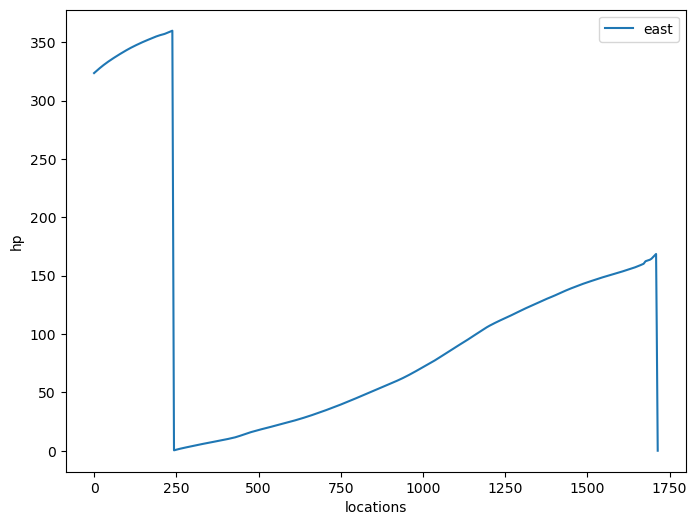

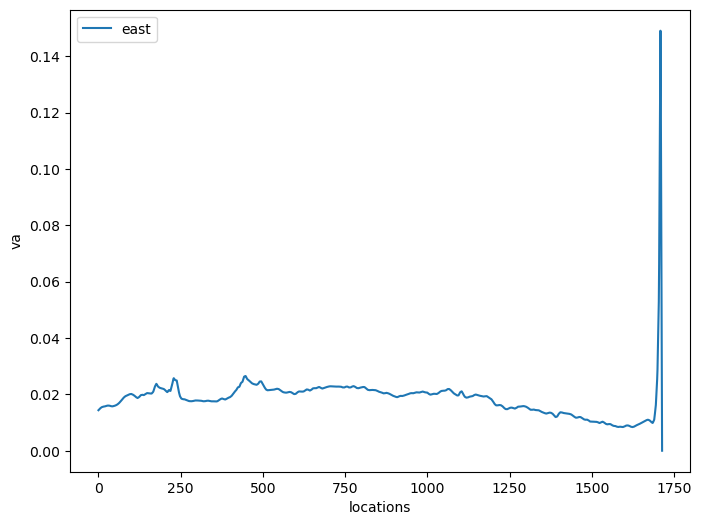

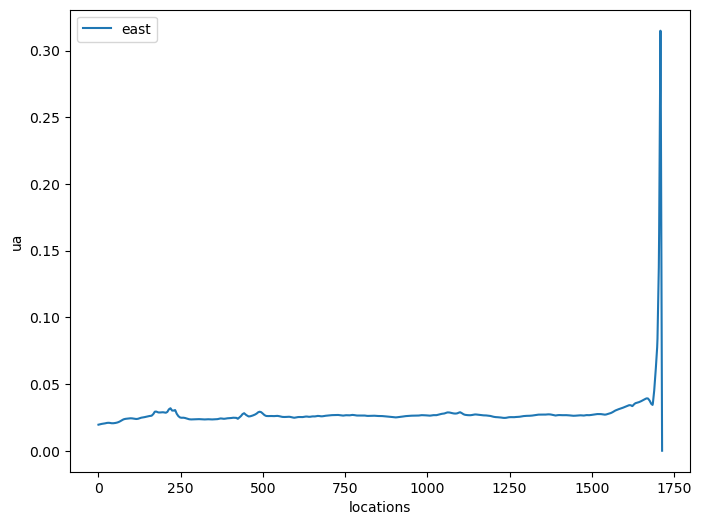

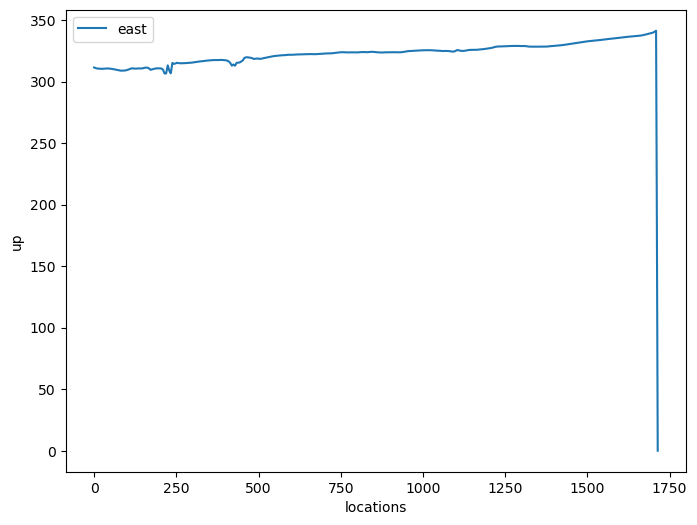

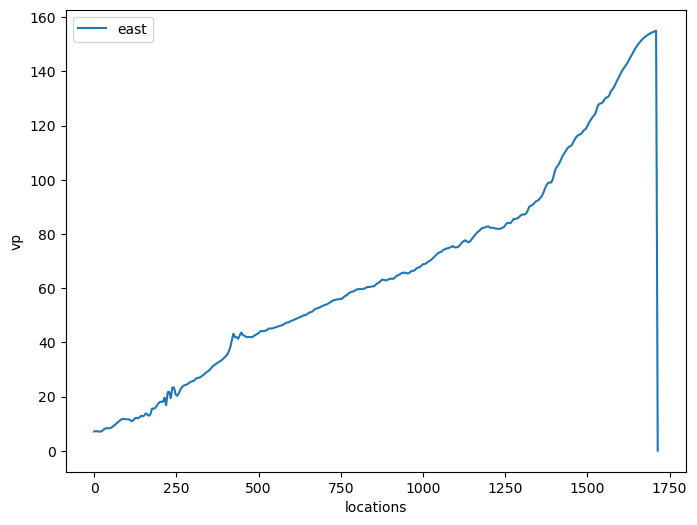

In [55]:
for b in segments:
    amplitude[b].isel(nc=0).plot(size=6,label=b)
    plt.legend()
    phase[b].isel(nc=0).plot(size=6,label=b)
    plt.legend()
    (v_amplitude[b].isel(nc=0)*1e-2).plot(size=6,label=b)
    plt.legend()
    (u_amplitude[b].isel(nc=0)*1e-2).plot(size=6,label=b)
    plt.legend()
    u_phase[b].isel(nc=0).plot(size=6,label=b) 
    plt.legend()
    v_phase[b].isel(nc=0).plot(size=6,label=b)
    plt.legend()

In [79]:
suffix={ 'north':'segment_001','east':'segment_003','south':'segment_002'}
susuffix={ 'north':'001','east':'003','south':'002'}
nz=len(amplitude['north'].nc)
ny=len(amplitude['north'].lat)
nx=len(amplitude['north'].lon)

times = xr.DataArray(
        pd.date_range('1990-01-01', periods=1),
        dims=['time']
    )

coords=[times, np.arange(nz), np.arange(ny), np.arange(nx)]
dims=['time', f'nz_{suffix[b]}', f'ny_{suffix[b]}', f'nx_{suffix[b]}']

coords={}

for b in segments:
    u_dvars = { f'uamp_{suffix[b]}':u_amplitude[b]*10-2, 'vamp_{suffix[b]}':v_amplitude[b]*10-2,
                           'uphase_{suffix[b]}':u_phase[b], 'vphase_{suffix[b]}':v_phase[b]}
    h_dvars = { f'hamp_{suffix[b]}':amplitude[b], 'hphase_{suffix[b]}': phase[b]}
    
    ds_h = xr.Dataset(h_dvars) 
    ds_u = xr.Dataset(u_dvars)
    
    write_obc(ds_u, f"tu{susuffix[b]}.nc")
    write_obc(ds_v, f"tz{susuffix[b]}.nc")


writing to tusegment_001.nc


KeyError: 'time'

In [61]:
print(amplitude['north'].coords,'----',len(amplitude['north'].locations))

Coordinates:
    lon      (locations) float64 -69.0 -68.96 -68.93 ... -9.07 -9.035 -9.0
    lat      (locations) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 ---- 1715


In [67]:
#========================================================================    
def write_obc(ds_, fname='obc_teste.nc', fill_value=1e20):
    import numpy as np
    print(f'writing to {fname}')
    view_results=False
    if view_results:
        print(ds_)
    for v in ds_:
        ds_[v].encoding['_FillValue']=fill_value
        if 'dudy' in v  or 'dvdx' in v :
            ds_[v].encoding['dtype']=np.float64
        else:
            ds_[v].encoding['dtype']=np.float32            
        ds_[v].encoding['missing_value']=fill_value        
    for v in ds_.coords:
        ds_[v].encoding['_FillValue']=fill_value
        ds_[v].encoding['missing_value']=fill_value
        ds_[v].encoding['dtype']=np.float32
        if v not in ['time','Time']:
                ds_[v].attrs = get_attrs(v)
    
    ds_.attrs = get_attrs('title')
    ds_['time'].encoding = get_attrs('time')
    
    ds_['time'].encoding = {'_FillValue':fill_value,'dtype':np.float32,'missing_value':fill_value}
    ds_['time'].encoding = get_attrs('time')
    ds_['time'].attrs['modulo'] = ' '

    ds_.to_netcdf( fname , unlimited_dims=('time')  )
    print(f'>{fname} saved')    
    
    return None
#=============================================================================
def get_attrs(var):                
     if var in ['ssh','SSH','zos']:
        attrs = {    'units' : "meter", 'long_name' : "effective sea level (eta_t + patm/(rho0*g)) on T cells" }
     elif var in ['temp','thetao']:
        attrs = {    'units' : "degrees C",'long_name' : "Potential thetaoerature" }
     elif var in [ 'salt', 'so']:
        attrs = {    'units' : "psu", 'long_name' : "Practical Salinity" } 
     elif var in ['u', 'uo']:
        attrs =  {    'units' : "m s-1",  'long_name' : "Barotropic-step Averaged Zonal Velocity" }
     elif var in [ 'v' , 'vo']:
        attrs =  {    'units' : "m s-1", 'long_name' : "Barotropic-step Averaged Zonal Velocity" }
     elif var in [ 'dz' ]:
        attrs = {    'units' : "meter" ,'long_name' : "Layer thicknesses"}
     elif var in ['diff']:
        attrs = { 'units' : "1/s", 'long_name' : "Part of vorticity" }
     elif var in ['lon'] :
        attrs = {'standard_name':"longitude",
                            'long_name' : "q point nominal longitude",
                            'axis' : "X",
                            'cartesian_axis' : "X",
                            'units' : "degrees"}  
     elif var in ['lat']:
        attrs = {'standard_name' : "latitude",
                                'long_name' : "h point nominal latitude",
                                'axis' : "Y",
                                'cartesian_axis' : "Y",
                                'units' : "degrees"}
     elif var in ['lev', 'depth', 'zl']:
        attrs={'axis' : "Z", 'cartesian_axis' : "Z",
                       'positive' : "down", 'units' : "meter", 'long_name' : "zstar depth"}
     elif var in ['Time', 'time']:
        attrs = { "units":'days since 1900-01-01 00:00:00', 
                'calendar' : "365_day",  'modulo' : " ",
                'axis' : "T"}
     elif var in ['title']:                           
        attrs = {'title':"remap_obc_from_glorys_to_MOM6 v3 output file",
                "references":""""Nicole C. Laureanti (INPE/BR) nlaureanti@gmail.com
                    More examples: https://github.com/ESMG/regionalMOM6_notebooks/blob/master/creating_obc_input_files/panArctic_OBC_from_global_MOM6.ipynb""",
                "source": "Glorys" }
     else:
        attrs = {'standard_name' : "null",
                                'long_name' : "null",
                                'units' : "null"} 
     return attrs